# Sensitivity analysis 
using OGGM edu glacier model
by Thomas Gölles, 2024

In [29]:
from oggm_edu import GlacierBed, Glacier, MassBalance, GlacierCollection
import SALib
from SALib.sample.sobol import sample
from SALib.analyze.sobol import analyze
import numpy as np

from matplotlib import pyplot as plt

print("salib version: ", SALib.__version__)

salib version:  1.4.7


## General OGGM definitions

In [ ]:
# Lets define the bed.
# Top and bottom altitude.
top = 5000
bottom = 0
# How far does the accumulation area extend?
accumulation_fraction = 1 / 3
# ELA altitude
ela_alt = (top - bottom) * (1 - accumulation_fraction)
# Accumulation area starts out as 1000 m. wide.
top_width = 1000
# 500 m. wide after ELA.
ela_width = 500

# Bed, note that we increase the map_dx here,
# we increase the grid point spacing.
bed = GlacierBed(
    altitudes=[top, ela_alt, bottom],
    widths=[top_width, ela_width, ela_width],
    map_dx=200,
)

Lets investigate how the mass blance influences the volume

In [ ]:
mb_gradient = 7
mass_balance = MassBalance(ela=ela_alt, gradient=mb_gradient)

In [ ]:
mass_balance.ela

In [ ]:
glacier = Glacier(bed, mass_balance=mass_balance)
glacier.progress_to_equilibrium()

In [ ]:
glacier

In [ ]:
glacier.plot()

In [ ]:
glacier.plot_history()

In [ ]:
glacier.history

We need a function which takes the mb_graident and gives us the resulting glacier in quilibrium. Then we varay the massbalance gradient and analyse the outcome.

In [ ]:
def evaluate_model(mb_gradient):
    mass_balance = MassBalance(ela=ela_alt, gradient=mb_gradient)
    glacier = Glacier(bed, mass_balance=mass_balance)
    glacier.progress_to_equilibrium()
    return glacier

## OAT sensitivity analysis

We interessed in the equilibirum glacier volume. And we want to know how the glacier reacts to massbalance gadients form 0.01 to 10.

In [ ]:
mb_gradient_min = 0.01
mb_gradient_max = 10
number_of_samples = 100
np.random.seed(0)  # so the results are reproducible and everyone gets the same results
mb_gradient_samples = np.random.uniform(
    mb_gradient_min, mb_gradient_max, number_of_samples
)
mb_gradient_samples

Ok, now we have the sample for our one one at the time sensitivity analysis.

Now lets generate a list with all the glaciers for the different mass balance gradients. We need an empty list to which we append the results run in a for loop:

In [ ]:
results = []
for mb_gradient in mb_gradient_samples:
    glacier = evaluate_model(mb_gradient)
    results.append(glacier)
    print(f"Done with mb_gradient: {mb_gradient}")

Now OGGM_edu has a usefull class called GlacierCollection

In [ ]:
ota_runs = GlacierCollection(results)

Now lets plot the equilibrium volume vs the mass balance gradient:

In [ ]:
plt.scatter(mb_gradient_samples, ota_runs.summary()["Volume [km3]"])
plt.xlabel("Mass balance gradient")
plt.ylabel("Volume [km3]")

What do we see here?

* The volume depends on the mass balance gradient
* it is non-linear
* it looks exponential
* where there is a lot of change at low mass balance gradients we have rader few points

What are soem real world implications*

* Glaciers with low mass balance gradient are more sensitive to climate

Limitations of OAT:

* no interactions between multiple factors 
* in reality multiply factors change at teh same time

OAT is usefull for inital insights but to capture feedbacks more advanced sensitivity analysis methods are needed.

## Using SALib and the Sobol method with one varible

Lets repeat the same experiment but using SALib.
First we need to defien the "priboblem", i.e, the epxeriment 
Again vary the mb gradient form 0.01 to 10

In [ ]:
problem = {"num_vars": 1, "names": ["mb_gradient"], "bounds": [[0.01, 10]]}

Instead of choosing randomly we use the Sobol sampler

In [ ]:
number_of_samples = 50

Now lets generate the samples. i.e. the list of inputs to test the model with

In [ ]:
param_values = sobol.sample(problem, number_of_samples)

In [ ]:
param_values

we reuse the function "elevate_model" from above. Which takes the mb_gradient as input and runs the glacier to equilibrium.
We need to adjust the for loop a bit since, the param_values with our sampel is a list of lists. (therfore the forcing[0])



In [ ]:
results = []
for forcing in param_values:
    mb_gradient = forcing[0]
    glacier = evaluate_model(forcing)
    results.append(glacier)
    print(f"Done with mb_gradient: {mb_gradient}")

In [ ]:
sobol_runs = GlacierCollection(results)

In [ ]:
# scatter plot of param_values vs. all_runs.summary()["Volume [km3]"]
plt.scatter(param_values, sobol_runs.summary()["Volume [km3]"])

What to we see here?

* more evently spaced samples
* the same conclustions as with the somple OAT approach.

Now we can actually analyse the Sobol Sensitivity measures:

In [30]:
sobol_result = analyze(problem, sobol_runs.summary()["Volume [km3]"].values)

In [31]:
sobol_result

{'S1': array([1.03197198]),
 'S1_conf': array([0.39282944]),
 'ST': array([0.99928594]),
 'ST_conf': array([0.24081578]),
 'S2': array([[nan]]),
 'S2_conf': array([[nan]])}

What do the values mean?

* S1 is the first-order sensitivity index and should be between 0 and 1
* S1 is larger than 1 => might need more samples. In this case it should be 1 since all the Variance of the output is form one input (the mass balance gradient)
* S1_conf quite large so significant uncertainties about the S1

* ST the Total Sensitivity Index sould also be 1 and the same is S1 since ther are not interactions with other variables

* S2 has a  not a number value (nan), since we only had one paramter.

So sobol sensitivity for one varialbe gives not much more insight then OTA, but now lets try it for multiple inputs


## Sobol sensitivity for multiple inputs

In [35]:
def evaluate_model_multi(mb_gradient, ela_width, add_to_with_at_top):
    top = 5000
    bottom = 0

    accumulation_fraction = 1 / 3
    ela_alt = (top - bottom) * (1 - accumulation_fraction)
    top_width = ela_width + add_to_with_at_top
    bed = GlacierBed(
        altitudes=[top, ela_alt, bottom],
        widths=[top_width, ela_width, ela_width],
        map_dx=200,
    )
    mass_balance = MassBalance(ela=ela_alt, gradient=mb_gradient)
    glacier = Glacier(bed, mass_balance=mass_balance)
    glacier.progress_to_equilibrium()
    return glacier

In [39]:
problem = {
    "num_vars": 3,
    "names": ["mb_gradient", "ela_width", "add_to_with_at_top"],
    "bounds": [
        [0.01, 10],
        [500, 2000],
        [0, 1000],
    ],
}

In [40]:
number_of_samples = 50

In [41]:
param_values = sample(problem, number_of_samples)

In [44]:
results = []
for forcing in param_values:
    glacier = evaluate_model_multi(
        mb_gradient=forcing[0], ela_width=forcing[1], add_to_with_at_top=forcing[2]
    )
    results.append(glacier)
    print(f"Done with forcings: {forcing}")

Done with forcings: [   7.19280545 1174.74333104  683.43541026]
Done with forcings: [9.76726892e-01 1.17474333e+03 6.83435410e+02]
Done with forcings: [   7.19280545 1838.0190758   683.43541026]
Done with forcings: [   7.19280545 1174.74333104   86.19310148]
Done with forcings: [   7.19280545 1838.0190758    86.19310148]
Done with forcings: [9.76726892e-01 1.17474333e+03 8.61931015e+01]
Done with forcings: [9.76726892e-01 1.83801908e+03 6.83435410e+02]
Done with forcings: [9.76726892e-01 1.83801908e+03 8.61931015e+01]
Done with forcings: [8.10892029e-01 1.65748920e+03 5.93973454e+01]
Done with forcings: [   6.77541345 1657.48919966   59.39734541]
Done with forcings: [8.10892029e-01 9.13826796e+02 5.93973454e+01]
Done with forcings: [8.10892029e-01 1.65748920e+03 9.51836203e+02]
Done with forcings: [8.10892029e-01 9.13826796e+02 9.51836203e+02]
Done with forcings: [   6.77541345 1657.48919966  951.83620322]
Done with forcings: [  6.77541345 913.82679576  59.39734541]
Done with forcings:

In [45]:
sobol_results_multi = GlacierCollection(results)

In [47]:
sobol_results_multi

,Id,Type,Age,Length [m],Area [km2],Volume [km3],Max ice thickness [m],Max ice velocity [m/yr],AAR [%],Response time [yrs],...,Basal sliding,Bed type,Top [m],Bottom [m],Width(s) [m],Length [km],ELA [m],Original ELA [m],Temperature bias [C],Gradient [mm/m/yr]
Glacier,,,,,,,,,,,,,,,,,,,,,
1,212,Glacier,128,33600.0,44.050393,12.822311,331.388012,840.436256,53.064023,NaN,...,0,Linear bed with a variable width,5000,0,"[1858.178741298616, 1174.7433310374618, 1174.7...",40.0,3333.333333,3333.333333,0,7.192805
2,213,Glacier,550,32000.0,42.170804,8.098186,218.599687,159.795087,53.200589,NaN,...,0,Linear bed with a variable width,5000,0,"[1858.178741298616, 1174.7433310374618, 1174.7...",40.0,3333.333333,3333.333333,0,0.976727
3,214,Glacier,136,32800.0,64.866043,18.622332,325.090900,782.612653,52.396171,NaN,...,0,Linear bed with a variable width,5000,0,"[2521.454486064613, 1838.0190758034587, 1838.0...",40.0,3333.333333,3333.333333,0,7.192805
4,215,Glacier,131,31400.0,37.464434,10.547657,315.129642,685.290395,51.084285,NaN,...,0,Linear bed with a variable width,5000,0,"[1260.936432518065, 1174.7433310374618, 1174.7...",40.0,3333.333333,3333.333333,0,7.192805
5,216,Glacier,144,31400.0,58.291293,16.333137,314.178132,672.382983,50.810668,NaN,...,0,Linear bed with a variable width,5000,0,"[1924.212177284062, 1838.0190758034587, 1838.0...",40.0,3333.333333,3333.333333,0,7.192805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,607,Glacier,911,31000.0,65.285985,10.825811,187.552428,83.732315,52.655049,NaN,...,0,Linear bed with a variable width,5000,0,"[2824.113211594522, 1908.0010717734694, 1908.0...",40.0,3333.333333,3333.333333,0,0.486181
397,608,Glacier,821,34200.0,29.080399,4.999022,201.088397,112.295684,55.709100,NaN,...,0,Linear bed with a variable width,5000,0,"[1586.9439346715808, 670.8317948505282, 670.83...",40.0,3333.333333,3333.333333,0,0.486181
398,609,Glacier,158,33200.0,69.483587,19.028133,310.631705,646.393024,52.220056,NaN,...,0,Linear bed with a variable width,5000,0,"[2824.113211594522, 1908.0010717734694, 1908.0...",40.0,3333.333333,3333.333333,0,5.435141


Lets now blot the mass balance gradient and volume

In [48]:
mb_gradients = param_values[:, 0]

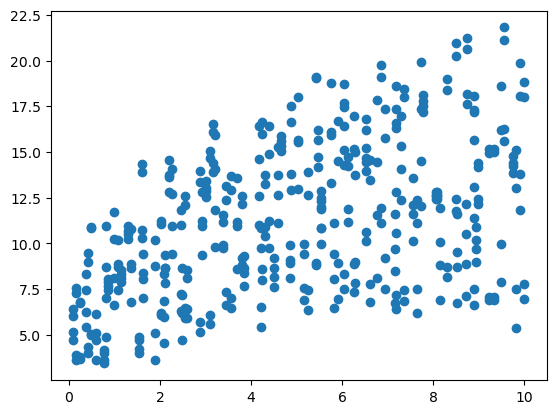

In [49]:
plt.scatter(mb_gradients, sobol_results_multi.summary()["Volume [km3]"])

What do we see here?